In [ ]:
#!pip install 'tensorflow==1.15.0'
#!pip install 'tensorflow-gpu==1.15'

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/english-language-learning-model/train_data.tfrecord
/kaggle/input/english-language-learning-model/__results__.html
/kaggle/input/english-language-learning-model/__notebook_source__.ipynb
/kaggle/input/english-language-learning-model/__notebook__.ipynb
/kaggle/input/english-language-learning-model/__output__.json
/kaggle/input/english-language-learning-model/custom.css
/kaggle/input/english-language-learning-model/model_text_kaggle.ml/saved_model.pb
/kaggle/input/english-language-learning-model/model_text_kaggle.ml/keras_metadata.pb
/kaggle/input/english-language-learning-model/model_text_kaggle.ml/variables/variables.index
/kaggle/input/english-language-learning-model/model_text_kaggle.ml/variables/variables.data-00000-of-00001
/kaggle/input/english-language-learning-model/model_text_kaggle_001.ml/saved_model.pb
/kaggle/input/english-language-learning-model/model_text_kaggle_001.ml/keras_metadata.pb
/kaggle/input/english-language-learning-model/model_text_kaggle_001.ml/va

In [2]:
train = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
ss = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
print(train.columns)

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')


# confirm data distrubutions

In [3]:
def make_l(v):
    return len(v)
for col in ["full_text"]:
    train[col+"_L"] = train[col].apply(make_l)

In [4]:
train.full_text_L.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

count    3911.000000
mean     2334.522373
std      1033.406009
min        82.000000
10%      1185.000000
20%      1471.000000
30%      1711.000000
40%      1950.000000
50%      2173.000000
60%      2413.000000
70%      2693.000000
80%      3066.000000
90%      3639.000000
100%     6044.000000
max      6044.000000
Name: full_text_L, dtype: float64

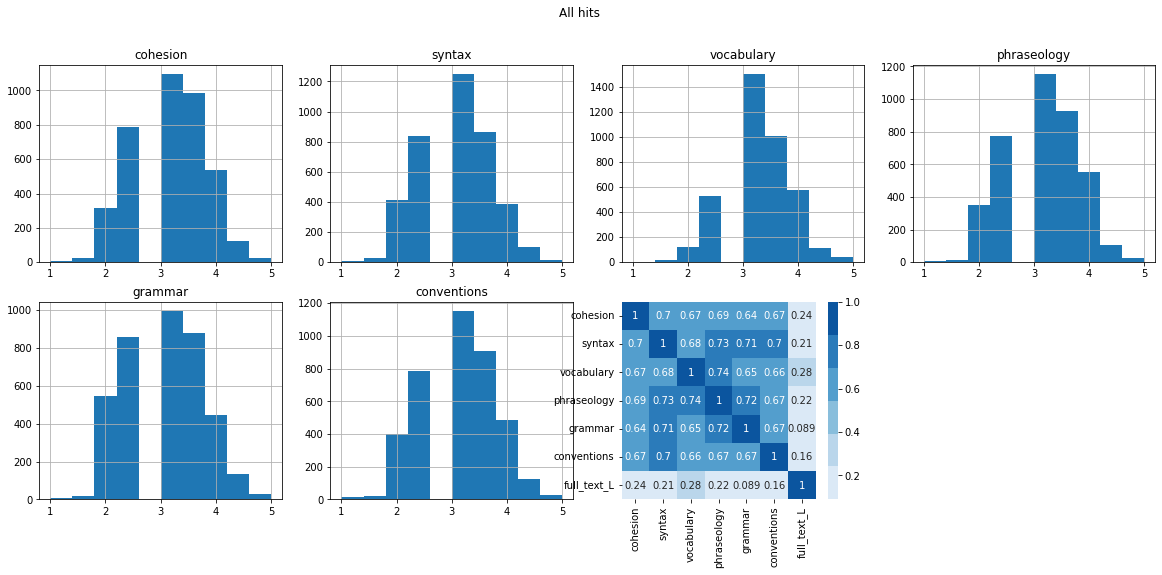

In [7]:
#'cohesion', 'syntax', 'vocabulary','phraseology', 'grammar', 'conventions'
plt.figure(figsize=(20, 8))
plt.subplot(2, 4, 1)
train.cohesion.hist()
plt.title("cohesion")

plt.subplot(2, 4, 2)
train.syntax.hist()
plt.title("syntax")

plt.subplot(2, 4, 3)
train.vocabulary.hist()
plt.title("vocabulary")

plt.subplot(2, 4, 4)
train.phraseology.hist()
plt.title("phraseology")

plt.subplot(2, 4, 5)
train.grammar.hist()
plt.title("grammar")

plt.subplot(2, 4, 6)
train.conventions.hist()
plt.title("conventions")

plt.subplot(2, 4, 7)
colormap = sns.color_palette("Blues")
sns.heatmap(train.corr(), annot=True, cmap=colormap);

plt.suptitle("All hits")
plt.show()

In [5]:
train.shape

(3911, 9)

In [10]:
max_seq_length = 512*6
max_seq_length

3072

# get model from bert

In [4]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel

2022-09-21 08:44:14.554510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 08:44:14.555586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 08:44:14.556303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 08:44:14.560112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased')
model = TFDistilBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-09-21 08:45:02.512949: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFDistilBertModel: ['nsp___cls', 'bert', 'mlm___cls']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['distilbert']
You should probably TRAIN this model on a down-stream task to be

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self,model):
        super().__init__()
        self.model = model
        self.model.trainable = False
        self.Bidirectional=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))        
        self.layersG = tf.keras.layers.GlobalMaxPool1D()
        self.layers1 = tf.keras.layers.Dense(50, activation="relu")
        self.layersD2 = tf.keras.layers.Dropout(0.2)
        self.layers3 = tf.keras.layers.Dense(30, activation="relu")
        self.layersD4 = tf.keras.layers.Dropout(0.2)
        self.layers5 = tf.keras.layers.Dense(10)
        self.layers6 = tf.keras.layers.Dense(6, activation="relu")
        
        self.relu = tf.keras.layers.ReLU()
        
    def call(self, inputs):
        input_ids = inputs["input_ids"]
        input_mask = inputs["input_mask"]
        print(input_ids[:,0:512])
        embedding_layer1  = self.model.distilbert(input_ids[:,0:512],input_mask[:,0:512])[0]
        #embedding_layer2  = self.model.distilbert(input_ids[:,512:512*2],input_mask[:,512:512*2])[0]
        embedding_layer3  = self.model.distilbert(input_ids[:,512*2:512*3],input_mask[:,512*2:512*3])[0]
        embedding_layer4  = self.model.distilbert(input_ids[:,512*3:512*4],input_mask[:,512*3:512*4])[0]
        #embedding_layer5  = self.model.distilbert(input_ids[:,512*4:512*5],input_mask[:,512*4:512*5])[0]
        embedding_layer6  = self.model.distilbert(input_ids[:,512*5:512*6],input_mask[:,512*5:512*6])[0]
        print(embedding_layer1)
        #embedding_layer = tf.concat([embedding_layer1,embedding_layer2,embedding_layer3,
        #                             embedding_layer4,embedding_layer5,embedding_layer6],axis = 1)
        embedding_layer = tf.concat([embedding_layer1,embedding_layer3,embedding_layer4,embedding_layer6],axis = 1)
        print(embedding_layer)
        X =self.Bidirectional(embedding_layer)
        X = self.layersG(X)
        X = self.layers1(X)
        X = self.layersD2(X)
        X = self.layers3(X)
        X = self.layersD4(X)
        X = self.layers5(X)
        X = self.layers6(X) 
        X = tf.subtract(X,5)
        X = tf.math.multiply(X,-1)
        X = self.relu(X)
        print(X)
        return X#tf.math.multiply(X,5)

# create train data(tf.data)

In [10]:
def create_tf_data_file(dt,output_file):
    tf_record_writer = tf.io.TFRecordWriter(output_file)
    for i in range(dt.shape[0]):
        texts = dt["full_text"][i]
        all_features = collections.OrderedDict()
        encode_plus_tokens = tokenizer.encode_plus(texts,padding='max_length',max_length=max_seq_length,truncation=True)
        input_ids = encode_plus_tokens["input_ids"]
        input_mask = encode_plus_tokens["attention_mask"]
        segment_ids = [0] *max_seq_length
        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=segment_ids))
        all_features["label_ids"] = tf.train.Feature(float_list=tf.train.FloatList(value=dt[['cohesion', 'syntax', 'vocabulary','phraseology', 'grammar', 'conventions']].values[i]))
        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())
    tf_record_writer.close()

In [ ]:
create_tf_data_file(train,"train_data.tfrecord")

In [11]:
#!cp -r ../input/english-language-learning-model/model_text_kaggle.ml model_text_kaggle.ml
#!cp ../input/english-language-learning-model/train_data.tfrecord train_data.tfrecord

# load train data

In [7]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
        #"segment_ids": record["segment_ids"],
    }
    y = record["label_ids"]
    return (x, y)
def _decode_record(record, name_to_features):
    """Decodes a record to a TensorFlow example."""
    return tf.io.parse_single_example(record, name_to_features)

In [8]:
def create_train_test_data(file_name,isTrain = False):
    dataset = tf.data.TFRecordDataset(file_name)
    if isTrain :
        dataset = dataset.repeat(40)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    name_to_features = {
            "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
            #"segment_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
            "label_ids": tf.io.FixedLenFeature([6], tf.float32),
        }
    drop_remainder=False
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=100,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )
    dataset.cache()
    re_dataset = dataset.map(select_data_and_label_from_record)
    return re_dataset

In [11]:
#train_dataset = create_train_test_data("train_data.tfrecord",True)
train_dataset = create_train_test_data("../input/english-language-learning-model/train_data.tfrecord",True)

In [12]:
train_dataset

<MapDataset shapes: ({input_ids: (None, 3072), input_mask: (None, 3072)}, (None, 6)), types: ({input_ids: tf.int64, input_mask: tf.int64}, tf.float32)>

In [14]:
learning_rate = 1e-6
epsilon = 1e-7

loss = tf.keras.losses.MeanSquaredError()
metric = tf.keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
#cup or gpu
#mode_text = MyModel(model)
mode_text = tf.keras.models.load_model("../input/english-language-learning-model/model_text_kaggle_001.ml")
mode_text.compile(optimizer=optimizer, loss=loss, metrics=[metric])

#tpu
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
#    mode_text = MyModel(model)
#    mode_text.compile(optimizer=optimizer, loss=loss, metrics=[metric])

2022-09-21 08:47:17.374674: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'bidirectional/forward_lstm/while' has 11 outputs but the _output_shapes attribute specifies shapes for 77 outputs. Output shapes may be inaccurate.
2022-09-21 08:47:17.377237: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'bidirectional/backward_lstm/while' has 11 outputs but the _output_shapes attribute specifies shapes for 77 outputs. Output shapes may be inaccurate.


In [ ]:
history = mode_text.fit(
    train_dataset,
    steps_per_epoch = 100,
    #batch_size=10,
    epochs=10)

2022-09-21 08:47:48.423632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
100/100 [==============================] - 2618s 26s/step - loss: 0.4689 - mean_squared_error: 0.4689
Epoch 2/10
100/100 [==============================] - 2571s 26s/step - loss: 0.4628 - mean_squared_error: 0.4628
Epoch 3/10
100/100 [==============================] - 2585s 26s/step - loss: 0.4689 - mean_squared_error: 0.4689
Epoch 4/10
100/100 [==============================] - 2614s 26s/step - loss: 0.4723 - mean_squared_error: 0.4723
Epoch 5/10
100/100 [==============================] - 2618s 26s/step - loss: 0.4655 - mean_squared_error: 0.4655
Epoch 6/10
100/100 [==============================] - 2622s 26s/step - loss: 0.4651 - mean_squared_error: 0.4651
Epoch 7/10
 48/100 [=============>................] - ETA: 22:41 - loss: 0.4657 - mean_squared_error: 0.4657

In [ ]:
'''
def get_test_data(dt):
    test_re = []
    for i in range(dt.shape[0]):
        texts = dt["full_text"][i]
        all_features = collections.OrderedDict()
        encode_plus_tokens = tokenizer.encode_plus(texts,padding='max_length',max_length=max_seq_length,truncation=True)
        input_ids = encode_plus_tokens["input_ids"]
        input_mask = encode_plus_tokens["attention_mask"]
        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=input_mask))
        test_re.append(all_features)
    return test_re
test_data =get_test_data(test)
'''

In [ ]:
#mode_text.predict(test_data)

In [20]:
#import joblib
#joblib.dump(mode_text,"model_text_kaggle.pkl")
mode_text.save("model_text_kaggle_001.ml")

In [ ]:
'''
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
'''

In [ ]:
!ls ./model_text_kaggle.ml

In [ ]:
#zip -r 压缩目录名 源目录 //压缩目录
!zip -r mymodel.zip ./model_text_kaggle.ml

In [22]:
!ll ./model_text_kaggle_001.ml

/bin/bash: ll: command not found


2022-09-19 12:28:13.403110: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
